In [6]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [7]:
# 이커머스 고객 이탈 예측: 앙상블 + 딥러닝 ROC/AUC
# ===========================================================

# 1. 라이브러리 설치 및 임포트


# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score


| 변수명                              | 한글명               | 설명                              |
| -------------------------------- | ----------------- | ------------------------------- |
| customer\_age                    | 고객 나이             | 고객의 현재 나이(연령)                   |
| gender                           | 성별                | 남/여 등 성별 정보                     |
| city\_tier                       | 도시 등급             | 거주지 도시 규모(예: 대도시=1, 중소도시=2 등)   |
| account\_age\_days               | 계정 생성 후 일수        | 고객 계정이 생성된 후 경과 일수              |
| preferred\_device                | 선호 기기             | 주로 사용하는 기기(PC, 모바일 등)           |
| total\_orders                    | 총 주문 횟수           | 지금까지 주문한 총 건수                   |
| total\_spent                     | 총 구매 금액           | 누적 결제 금액(예: 원화/달러)              |
| avg\_order\_value                | 평균 주문 금액          | 1회 주문 당 평균 결제 금액                |
| days\_since\_last\_order         | 마지막 주문 후 경과일      | 마지막 주문 후 며칠 지났는지                |
| website\_sessions\_30d           | 최근 30일 웹사이트 접속 수  | 최근 한 달 동안 PC 웹사이트 방문/활동 횟수      |
| mobile\_app\_sessions\_30d       | 최근 30일 모바일 앱 접속 수 | 최근 한 달 동안 모바일 앱 방문/활동 횟수        |
| avg\_session\_duration           | 평균 세션 시간          | 접속 1회당 평균 이용 시간(분/초 단위)         |
| preferred\_category              | 선호 카테고리           | 주로 구매하는 상품 카테고리(예: 의류, 가전 등)    |
| support\_tickets                 | 고객센터 문의 건수        | 누적 고객센터 문의(티켓) 건수               |
| avg\_complaint\_resolution\_days | 평균 불만 처리일수        | 고객 불만/문의 해결까지 평균 소요 일수          |
| product\_returns                 | 상품 반품 건수          | 반품(리턴) 요청/처리된 상품 수              |
| email\_open\_rate                | 이메일 오픈율           | 발송한 마케팅 메일 중 열어본 비율 (%)         |
| email\_click\_rate               | 이메일 클릭률           | 마케팅 메일 내 링크 클릭 비율 (%)           |
| sms\_opt\_in                     | SMS 수신 동의 여부      | 문자 마케팅 수신 동의(1=예, 0=아니오)        |
| push\_notification\_enabled      | 푸시 알림 설정 여부       | 앱 푸시 알림 허용(1=예, 0=아니오)          |
| discount\_usage\_count           | 할인쿠폰 사용 횟수        | 할인/프로모션 쿠폰 사용 누적 건수             |
| coupon\_conversion\_rate         | 쿠폰 전환율            | 쿠폰 받은 고객 중 실제 사용(구매) 비율 (%)     |
| loyalty\_points\_balance         | 적립 포인트 잔액         | 현재 보유 중인 멤버십/포인트                |
| preferred\_payment               | 선호 결제 수단          | 주로 사용하는 결제 방식(카드, 계좌이체, 간편결제 등) |
| payment\_failures                | 결제 실패 건수          | 결제 시도 중 오류/실패 발생 횟수             |
| num\_reviews\_written            | 작성 리뷰 수           | 누적 상품 리뷰 작성 건수                  |
| avg\_rating\_given               | 평균 리뷰 평점          | 고객이 남긴 평점의 평균값(예: 1\~5점)        |
| black\_friday\_purchases         | 블랙프라이데이 구매 횟수     | 블랙프라이데이 기간 내 구매 건수              |
| seasonal\_purchases              | 계절성 구매 건수         | 특정 시즌(예: 연말, 명절) 기간 내 구매 건수     |
| churn (customer\_churn)          | 이탈 여부             | 고객 이탈(Churn) 여부(1=이탈, 0=유지)     |


In [8]:

# 딥러닝 (TensorFlow/Keras가 없으면 스킵)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping
    DEEP_LEARNING_AVAILABLE = True
    print(f" TensorFlow 버전: {tf.__version__}")
    tf.random.set_seed(42)
except ImportError:
    DEEP_LEARNING_AVAILABLE = False
    print("TensorFlow가 없어서 딥러닝 모델은 스킵됩니다.")
    print("설치하려면: !pip install tensorflow")



# 2. 이커머스 고객 데이터 생성
print(" 2단계: 이커머스 고객 데이터 생성")
print("-" * 60)

np.random.seed(42)
n_customers = 8000

# 기본 고객 정보
customer_age = np.random.normal(35, 12, n_customers).clip(18, 75)
gender = np.random.choice(['M', 'F'], n_customers, p=[0.48, 0.52])
city_tier = np.random.choice(['Tier1', 'Tier2', 'Tier3'], n_customers, p=[0.3, 0.45, 0.25])

# 계정 정보
account_age_days = np.random.exponential(400, n_customers).clip(30, 2000)
preferred_device = np.random.choice(['Mobile', 'Desktop', 'Tablet'],
                                  n_customers, p=[0.65, 0.3, 0.05])

# 구매 행동 패턴
total_orders = np.random.negative_binomial(10, 0.3, n_customers) + 1
total_spent = []
avg_order_values = []

for orders in total_orders:
    # 주문 수에 따라 총 지출액 결정 (현실적인 패턴)
    base_spend = np.random.lognormal(5.5, 1.2) * orders
    total_spent.append(max(base_spend, 20))  # 최소 20달러
    avg_order_values.append(total_spent[-1] / orders)

total_spent = np.array(total_spent)
avg_order_values = np.array(avg_order_values)

# 최근 활동 패턴
days_since_last_order = np.random.exponential(45, n_customers).clip(0, 365)
website_sessions_30d = np.random.negative_binomial(15, 0.4, n_customers)
mobile_app_sessions_30d = np.random.negative_binomial(8, 0.3, n_customers)
avg_session_duration = np.random.lognormal(2.5, 0.8, n_customers).clip(1, 60)  # 분 단위

# 상품 카테고리 선호도
preferred_category = np.random.choice(
    ['Electronics', 'Fashion', 'Home_Garden', 'Books_Media', 'Sports_Outdoors'],
    n_customers, p=[0.25, 0.35, 0.2, 0.1, 0.1]
)

# 고객 서비스 관련
support_tickets = np.random.poisson(1.5, n_customers)
avg_complaint_resolution_days = np.random.exponential(3, n_customers).clip(0, 30)
product_returns = np.random.poisson(0.8, n_customers)

# 마케팅 반응도
email_open_rate = np.random.beta(3, 5, n_customers)  # 보통 20-40%
email_click_rate = email_open_rate * np.random.beta(2, 8, n_customers)  # 오픈률의 일부
sms_opt_in = np.random.binomial(1, 0.3, n_customers)
push_notification_enabled = np.random.binomial(1, 0.7, n_customers)

# 할인 및 프로모션 사용
discount_usage_count = np.random.poisson(2, n_customers)
coupon_conversion_rate = np.random.beta(2, 6, n_customers)
loyalty_points_balance = np.random.exponential(500, n_customers)

# 결제 관련
preferred_payment = np.random.choice(
    ['Credit_Card', 'Debit_Card', 'Digital_Wallet', 'Bank_Transfer'],
    n_customers, p=[0.45, 0.25, 0.25, 0.05]
)
payment_failures = np.random.poisson(0.3, n_customers)

# 상품 리뷰 및 평점
num_reviews_written = np.random.poisson(1.8, n_customers)
avg_rating_given = np.random.normal(4.1, 0.9, n_customers).clip(1, 5)

# 계절성 및 특별 이벤트 참여
black_friday_purchases = np.random.poisson(1.2, n_customers)
seasonal_purchases = np.random.poisson(2.5, n_customers)

#  고객 이탈 확률 계산 (실제 이커머스 패턴 반영)
print(" 고객 이탈 패턴 생성 중...")

# 다양한 요인들의 가중치를 고려한 이탈 확률
churn_prob = np.zeros(n_customers)

# 1. 비활성화 요인 (40% 가중치)
churn_prob += 0.4 * np.clip(days_since_last_order / 180, 0, 1)  # 오래된 마지막 주문
churn_prob += 0.1 * (1 - np.clip(website_sessions_30d / 30, 0, 1))  # 낮은 웹사이트 활동
churn_prob += 0.1 * (1 - np.clip(mobile_app_sessions_30d / 20, 0, 1))  # 낮은 앱 사용

# 2. 구매력 및 참여도 (25% 가중치)
churn_prob += 0.15 * (1 - np.clip(total_spent / 1000, 0, 1))  # 낮은 총 구매액
churn_prob += 0.1 * (1 - np.clip(total_orders / 20, 0, 1))  # 적은 주문 횟수

# 3. 불만족 지표 (20% 가중치)
churn_prob += 0.1 * np.clip(support_tickets / 10, 0, 1)  # 많은 고객 서비스 문의
churn_prob += 0.05 * np.clip(product_returns / 5, 0, 1)  # 높은 반품률
churn_prob += 0.05 * np.clip(payment_failures / 3, 0, 1)  # 결제 실패

# 4. 마케팅 반응도 (10% 가중치)
churn_prob += 0.05 * (1 - email_open_rate)  # 낮은 이메일 오픈률
churn_prob += 0.05 * (1 - push_notification_enabled)  # 푸시 알림 비활성화

# 5. 기타 요인 (5% 가중치)
churn_prob += 0.03 * (1 - sms_opt_in)  # SMS 수신 거부
churn_prob += 0.02 * (1 - np.clip(loyalty_points_balance / 1000, 0, 1))  # 낮은 포인트

# 노이즈 추가 및 정규화
churn_prob += np.random.normal(0, 0.1, n_customers)
churn_prob = np.clip(churn_prob, 0, 1)

# 이탈 결정 (30% 이탈률 목표)
churn_threshold = np.percentile(churn_prob, 70)  # 상위 30%가 이탈
customer_churn = (churn_prob > churn_threshold).astype(int)

# 데이터프레임 생성
df = pd.DataFrame({
    'customer_age': customer_age,
    'gender': gender,
    'city_tier': city_tier,
    'account_age_days': account_age_days,
    'preferred_device': preferred_device,
    'total_orders': total_orders,
    'total_spent': total_spent,
    'avg_order_value': avg_order_values,
    'days_since_last_order': days_since_last_order,
    'website_sessions_30d': website_sessions_30d,
    'mobile_app_sessions_30d': mobile_app_sessions_30d,
    'avg_session_duration': avg_session_duration,
    'preferred_category': preferred_category,
    'support_tickets': support_tickets,
    'avg_complaint_resolution_days': avg_complaint_resolution_days,
    'product_returns': product_returns,
    'email_open_rate': email_open_rate,
    'email_click_rate': email_click_rate,
    'sms_opt_in': sms_opt_in,
    'push_notification_enabled': push_notification_enabled,
    'discount_usage_count': discount_usage_count,
    'coupon_conversion_rate': coupon_conversion_rate,
    'loyalty_points_balance': loyalty_points_balance,
    'preferred_payment': preferred_payment,
    'payment_failures': payment_failures,
    'num_reviews_written': num_reviews_written,
    'avg_rating_given': avg_rating_given,
    'black_friday_purchases': black_friday_purchases,
    'seasonal_purchases': seasonal_purchases,
    'churn': customer_churn
})

print(f" 데이터 생성 완료!")
print(f" 총 고객 수: {len(df):,}명")
print(f" 이탈 고객: {df['churn'].sum():,}명 ({df['churn'].mean()*100:.1f}%)")
print(f" 유지 고객: {(len(df) - df['churn'].sum()):,}명 ({(1-df['churn'].mean())*100:.1f}%)")


 TensorFlow 버전: 2.18.0
 2단계: 이커머스 고객 데이터 생성
------------------------------------------------------------
 고객 이탈 패턴 생성 중...
 데이터 생성 완료!
 총 고객 수: 8,000명
 이탈 고객: 2,400명 (30.0%)
 유지 고객: 5,600명 (70.0%)


In [9]:
df

,customer_age,gender,city_tier,account_age_days,preferred_device,total_orders,total_spent,avg_order_value,days_since_last_order,website_sessions_30d,...,discount_usage_count,coupon_conversion_rate,loyalty_points_balance,preferred_payment,payment_failures,num_reviews_written,avg_rating_given,black_friday_purchases,seasonal_purchases,churn
0,40.960570,M,Tier2,223.587528,Mobile,28,9541.049945,340.751784,30.721079,28,...,2,0.315209,1111.780996,Credit_Card,0,1,4.449526,0,2,0
1,33.340828,M,Tier2,109.023089,Mobile,22,7296.472675,331.657849,21.054603,14,...,2,0.086536,166.995788,Credit_Card,0,3,3.785920,2,2,0
2,42.772262,F,Tier2,569.384650,Mobile,26,18259.356577,702.282945,3.816976,28,...,2,0.172192,202.835865,Credit_Card,0,1,4.046267,3,3,0
3,53.276358,M,Tier2,824.579307,Mobile,37,4250.219735,114.870804,17.984376,23,...,1,0.198857,690.349923,Credit_Card,1,3,4.890111,1,4,0
4,32.190160,F,Tier1,132.144394,Mobile,15,826.528728,55.101915,140.232397,14,...,2,0.527272,107.860699,Credit_Card,1,3,4.549314,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,61.518268,F,Tier2,167.829909,Mobile,23,2837.950460,123.389150,9.582454,24,...,4,0.377969,854.203482,Debit_Card,0,1,3.168797,3,1,0
7996,38.923934,F,Tier2,236.757966,Mobile,29,5727.033256,197.483905,24.059066,25,...,2,0.266038,2415.049169,Digital_Wallet,0,1,3.711606,3,2,0
7997,24.978506,F,Tier2,97.642538,Mobile,27,5033.366917,186.420997,78.475393,27,...,1,0.168345,2.964873,Debit_Card,1,1,4.677273,0,2,0
7998,54.834957,M,Tier2,42.242745,Tablet,26,11938.765742,459.183298,2.338593,32,...,2,0.349980,819.670136,Debit_Card,0,0,4.600751,1,6,0



 3단계: 탐색적 데이터 분석
------------------------------------------------------------
 주요 지표 통계:
       total_spent  total_orders  days_since_last_order  website_sessions_30d  \
count      8000.00       8000.00                8000.00               8000.00   
mean      12225.05         24.41                  44.15                 22.43   
std       22468.67          8.86                  43.87                  7.45   
min          56.81          3.00                   0.00                  3.00   
25%        2433.58         18.00                  12.63                 17.00   
50%        5698.53         23.00                  31.21                 22.00   
75%       13147.64         30.00                  61.01                 27.00   
max      483914.57         70.00                 365.00                 64.00   

       email_open_rate  
count          8000.00  
mean              0.37  
std               0.16  
min               0.02  
25%               0.25  
50%               0.36  
75%  

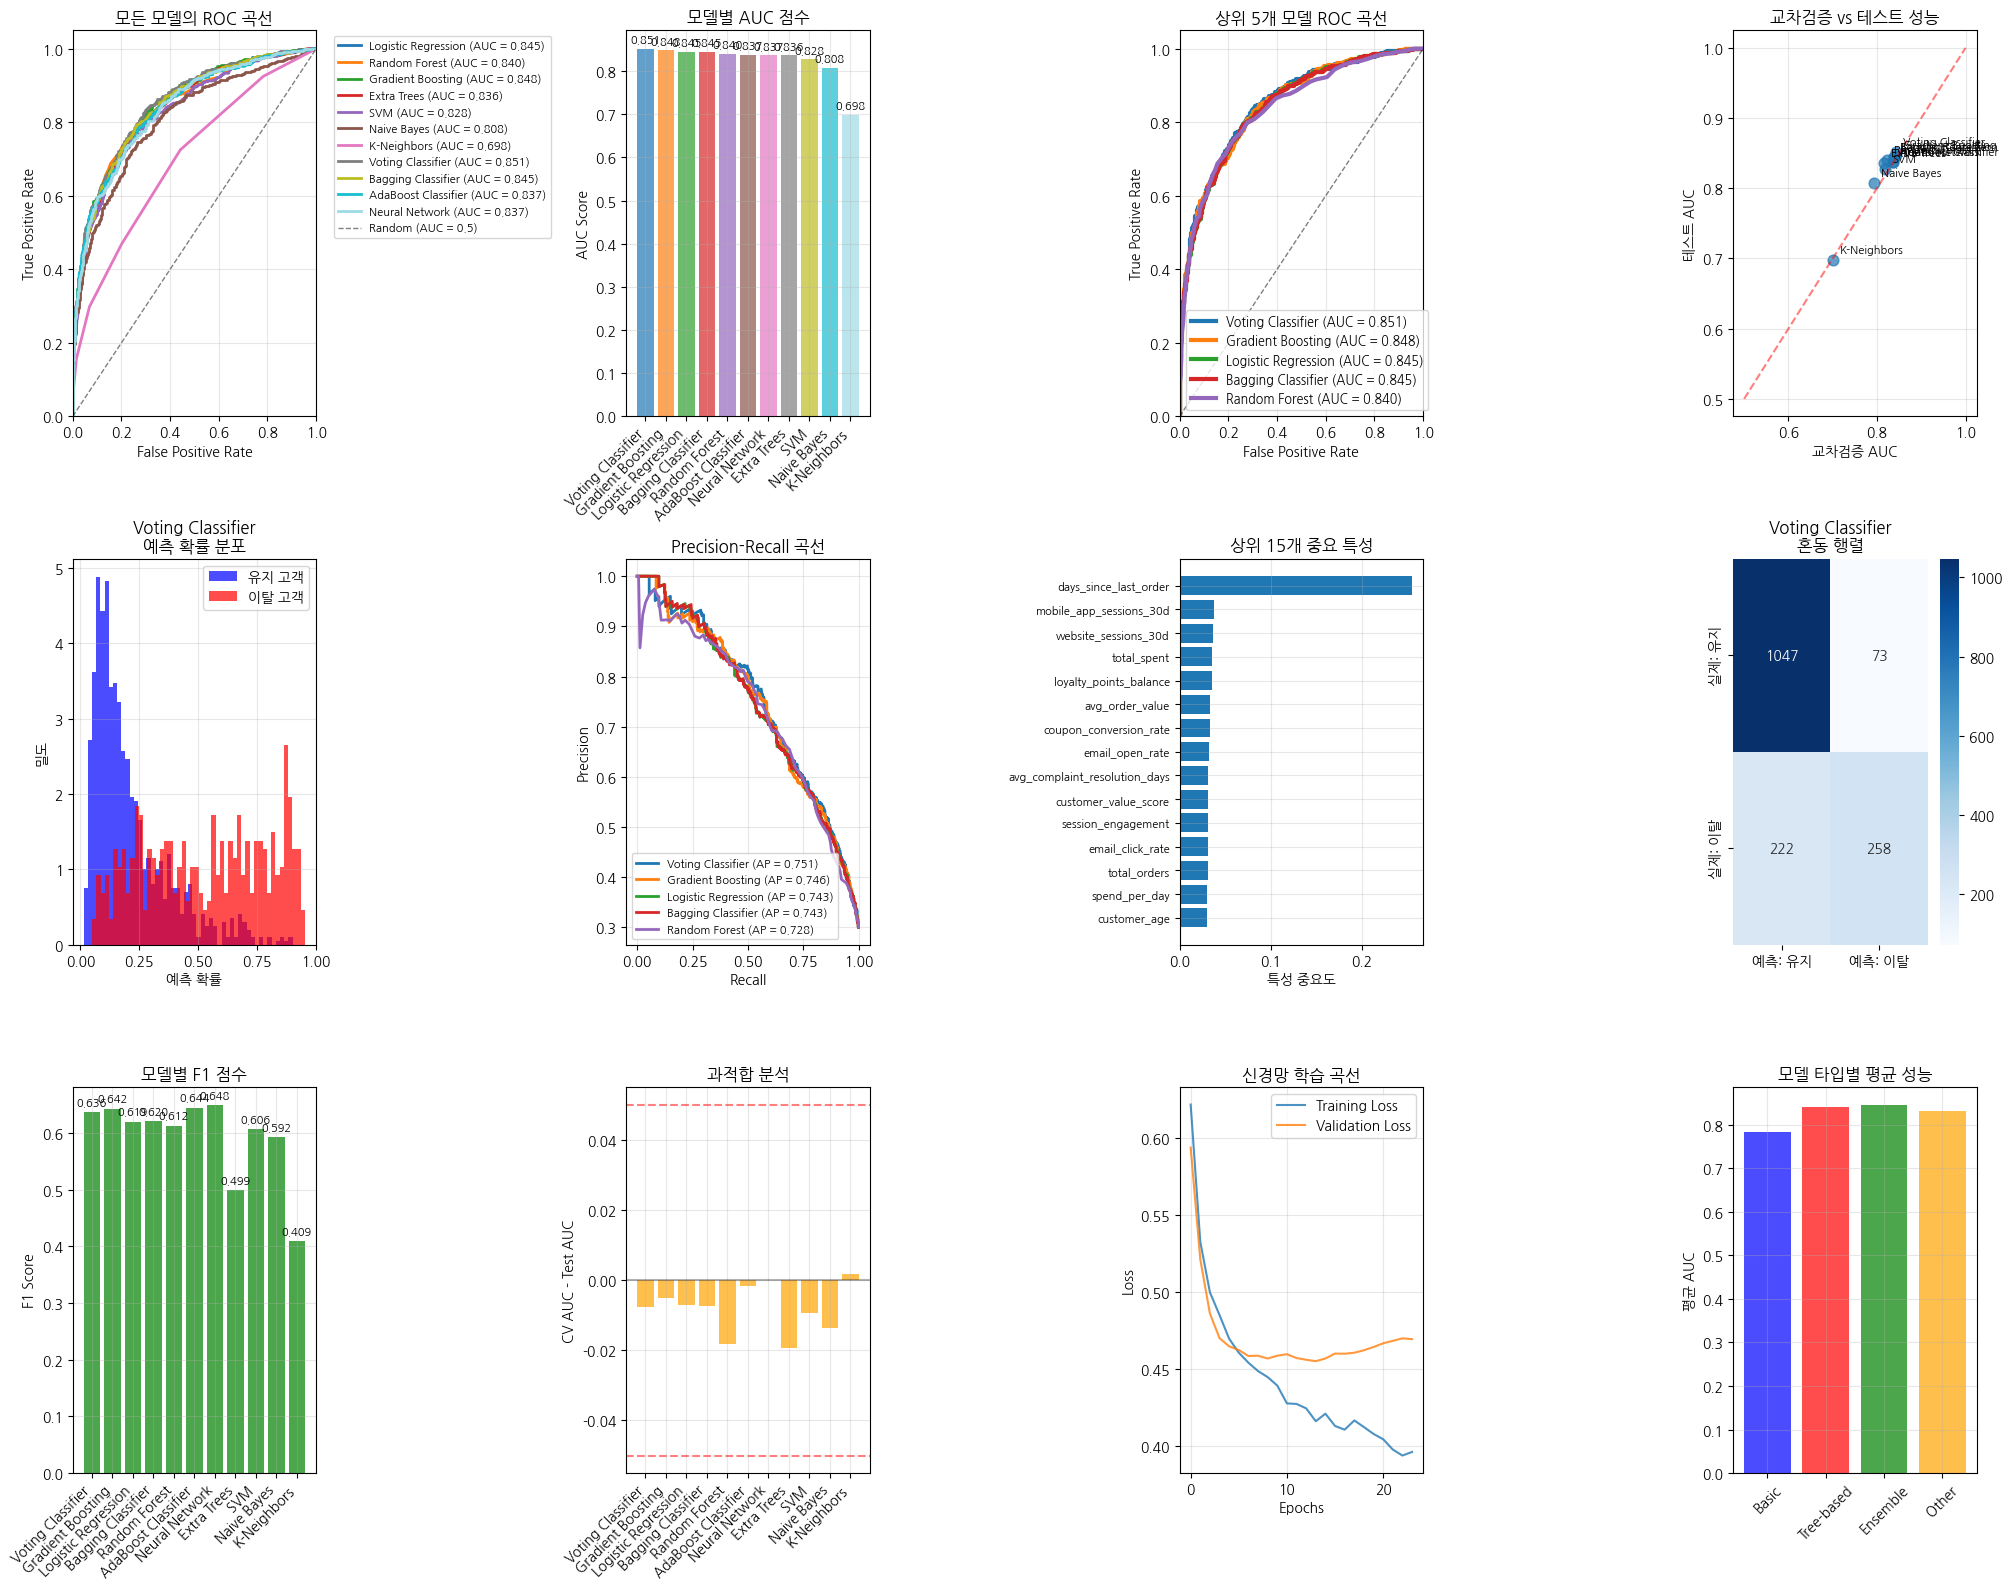


 8단계: 최종 분석 및 비즈니스 권장사항
------------------------------------------------------------
 최고 성능 모델: Voting Classifier
    테스트 AUC: 0.8515
    교차검증 AUC: 0.8437 (±0.0129)
    F1 점수: 0.6363

 비즈니스 인사이트:
 고객 이탈에 가장 영향을 미치는 요인들:
    1. days_since_last_order: 0.2550
    2. mobile_app_sessions_30d: 0.0375
    3. website_sessions_30d: 0.0372
    4. total_spent: 0.0357
    5. loyalty_points_balance: 0.0354
    6. avg_order_value: 0.0335
    7. coupon_conversion_rate: 0.0332
    8. email_open_rate: 0.0328
    9. avg_complaint_resolution_days: 0.0317
   10. customer_value_score: 0.0316

 모델 선택 권장사항:
1. 성능 우선: Voting Classifier (AUC: 0.851)
2. 안정성 우선: Neural Network
3. 해석 가능성: Logistic Regression 또는 Random Forest

 분석 완료! 총 11개 모델로 고객 이탈 예측 성능을 비교했습니다.


In [10]:
# 3. 탐색적 데이터 분석
print(f"\n 3단계: 탐색적 데이터 분석")
print("-" * 60)

# 기본 통계
print(" 주요 지표 통계:")
key_metrics = ['total_spent', 'total_orders', 'days_since_last_order',
               'website_sessions_30d', 'email_open_rate']
print(df[key_metrics].describe().round(2))

# 이탈률 by 카테고리
print(f"\n 카테고리별 이탈률:")
churn_by_category = df.groupby('preferred_category')['churn'].agg(['count', 'sum', 'mean'])
churn_by_category.columns = ['총고객수', '이탈고객수', '이탈률']
churn_by_category['이탈률'] = (churn_by_category['이탈률'] * 100).round(1)
print(churn_by_category)

print()

# 4. 데이터 전처리
print(" 4단계: 데이터 전처리")
print("-" * 60)

# 범주형 변수 인코딩
categorical_columns = ['gender', 'city_tier', 'preferred_device', 'preferred_category', 'preferred_payment']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# 특성 엔지니어링
df['orders_per_day'] = df['total_orders'] / df['account_age_days']
df['spend_per_day'] = df['total_spent'] / df['account_age_days']
df['session_engagement'] = (df['website_sessions_30d'] + df['mobile_app_sessions_30d']) * df['avg_session_duration']
df['customer_value_score'] = (df['total_spent'] * df['total_orders']) / (df['account_age_days'] + 1)
df['service_satisfaction'] = 1 / (df['support_tickets'] + df['product_returns'] + 1)

# 특성 선택
feature_columns = [
    'customer_age', 'account_age_days', 'total_orders', 'total_spent', 'avg_order_value',
    'days_since_last_order', 'website_sessions_30d', 'mobile_app_sessions_30d',
    'avg_session_duration', 'support_tickets', 'avg_complaint_resolution_days',
    'product_returns', 'email_open_rate', 'email_click_rate', 'sms_opt_in',
    'push_notification_enabled', 'discount_usage_count', 'coupon_conversion_rate',
    'loyalty_points_balance', 'payment_failures', 'num_reviews_written',
    'avg_rating_given', 'black_friday_purchases', 'seasonal_purchases',
    'orders_per_day', 'spend_per_day', 'session_engagement',
    'customer_value_score', 'service_satisfaction'
] + [f'{col}_encoded' for col in categorical_columns]

X = df[feature_columns]
y = df['churn']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" 특성 개수: {len(feature_columns)}")
print(f" 훈련 세트: {X_train_scaled.shape}")
print(f" 테스트 세트: {X_test_scaled.shape}")

# 5. 모델 정의 및 학습
print(f"\n 5단계: 다양한 모델 정의 및 학습")
print("-" * 60)

# 기본 모델들
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=7)
}

# 앙상블 모델들
ensemble_models = {
    'Voting Classifier': VotingClassifier([
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ], voting='soft'),
    'Bagging Classifier': BaggingClassifier(
        estimator=LogisticRegression(random_state=42, max_iter=1000),
        n_estimators=50, random_state=42
    ),

    'AdaBoost Classifier': AdaBoostClassifier(random_state=42, n_estimators=50)
}

# 모든 모델 합치기
all_models = {**models, **ensemble_models}

# 딥러닝 모델 정의
if DEEP_LEARNING_AVAILABLE:
    def create_neural_network(input_dim):
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),

            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# 6. 모델 학습 및 성능 평가
print(" 모델 학습 및 성능 평가 중...")

results = {}
model_predictions = {}

# 기존 ML 모델들 학습
for name, model in all_models.items():
    print(f" {name} 학습 중...")

    # 교차 검증
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='roc_auc')

    # 모델 학습
    model.fit(X_train_scaled, y_train)

    # 예측
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)
        # decision_function 결과를 확률로 변환
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

    y_pred = (y_pred_proba > 0.5).astype(int)

    # ROC 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # 결과 저장
    results[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'f1': f1_score(y_test, y_pred)
    }
    model_predictions[name] = y_pred_proba

# 딥러닝 모델 학습
if DEEP_LEARNING_AVAILABLE:
    print(" Neural Network 학습 중...")

    # 모델 생성 및 학습
    nn_model = create_neural_network(X_train_scaled.shape[1])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = nn_model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # 예측
    nn_pred_proba = nn_model.predict(X_test_scaled, verbose=0).ravel()
    nn_pred = (nn_pred_proba > 0.5).astype(int)

    # ROC 계산
    fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)
    roc_auc_nn = auc(fpr_nn, tpr_nn)

    results['Neural Network'] = {
        'fpr': fpr_nn,
        'tpr': tpr_nn,
        'auc': roc_auc_nn,
        'cv_mean': roc_auc_nn,  # 딥러닝은 별도 교차검증 안함
        'cv_std': 0,
        'f1': f1_score(y_test, nn_pred)
    }
    model_predictions['Neural Network'] = nn_pred_proba

print(" 모든 모델 학습 완료!")

# 7. 결과 시각화
print(f"\n 7단계: 결과 시각화 및 분석")
print("-" * 60)

# 성능 요약
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_AUC': [results[name]['auc'] for name in results.keys()],
    'CV_AUC_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_AUC_Std': [results[name]['cv_std'] for name in results.keys()],
    'F1_Score': [results[name]['f1'] for name in results.keys()]
})

performance_df['Overfitting'] = performance_df['CV_AUC_Mean'] - performance_df['Test_AUC']
performance_df = performance_df.sort_values('Test_AUC', ascending=False)

print(" 모델 성능 순위:")
print(performance_df.round(4))

# 시각화
plt.figure(figsize=(20, 16))

# 1. 모든 모델의 ROC 곡선
plt.subplot(3, 4, 1)
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

for (name, data), color in zip(results.items(), colors):
    plt.plot(data['fpr'], data['tpr'], color=color, lw=2,
             label=f'{name} (AUC = {data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('모든 모델의 ROC 곡선')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# 2. AUC 점수 비교
plt.subplot(3, 4, 2)
model_names = performance_df['Model'].values
auc_scores = performance_df['Test_AUC'].values

bars = plt.bar(range(len(model_names)), auc_scores, color=colors[:len(model_names)], alpha=0.7)
plt.ylabel('AUC Score')
plt.title('모델별 AUC 점수')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 3. 상위 5개 모델 ROC 곡선
plt.subplot(3, 4, 3)
top_5_models = performance_df.head(5)['Model'].values

for name in top_5_models:
    data = results[name]
    plt.plot(data['fpr'], data['tpr'], lw=3,
             label=f'{name} (AUC = {data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('상위 5개 모델 ROC 곡선')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 4. 교차검증 vs 테스트 성능
plt.subplot(3, 4, 4)
cv_means = performance_df['CV_AUC_Mean'].values
test_scores = performance_df['Test_AUC'].values

plt.scatter(cv_means, test_scores, alpha=0.7, s=60)
plt.plot([0.5, 1], [0.5, 1], 'r--', alpha=0.5)
plt.xlabel('교차검증 AUC')
plt.ylabel('테스트 AUC')
plt.title('교차검증 vs 테스트 성능')

for i, name in enumerate(performance_df['Model'].values):
    plt.annotate(name, (cv_means[i], test_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.grid(True, alpha=0.3)

# 5. 최고 성능 모델 예측 확률 분포
best_model_name = performance_df.iloc[0]['Model']
best_predictions = model_predictions[best_model_name]

plt.subplot(3, 4, 5)
plt.hist(best_predictions[y_test == 0], bins=50, alpha=0.7,
         label='유지 고객', color='blue', density=True)
plt.hist(best_predictions[y_test == 1], bins=50, alpha=0.7,
         label='이탈 고객', color='red', density=True)
plt.xlabel('예측 확률')
plt.ylabel('밀도')
plt.title(f'{best_model_name}\n예측 확률 분포')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Precision-Recall 곡선 (상위 5개)
plt.subplot(3, 4, 6)
for name in top_5_models:
    precision, recall, _ = precision_recall_curve(y_test, model_predictions[name])
    avg_precision = average_precision_score(y_test, model_predictions[name])
    plt.plot(recall, precision, lw=2,
             label=f'{name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall 곡선')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 7. 특성 중요도 (Random Forest)
if 'Random Forest' in all_models:
    plt.subplot(3, 4, 7)
    rf_model = all_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-15:]

    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
    plt.yticks(range(len(top_features_idx)),
               [feature_columns[i] for i in top_features_idx], fontsize=8)
    plt.xlabel('특성 중요도')
    plt.title('상위 15개 중요 특성')
    plt.grid(True, alpha=0.3)

# 8. 혼동 행렬 (최고 성능 모델)
plt.subplot(3, 4, 8)
y_pred_best = (best_predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['예측: 유지', '예측: 이탈'],
            yticklabels=['실제: 유지', '실제: 이탈'])
plt.title(f'{best_model_name}\n혼동 행렬')

# 9. F1 Score 비교
plt.subplot(3, 4, 9)
f1_scores = performance_df['F1_Score'].values
bars = plt.bar(range(len(model_names)), f1_scores, alpha=0.7, color='green')
plt.ylabel('F1 Score')
plt.title('모델별 F1 점수')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 10. 과적합 분석
plt.subplot(3, 4, 10)
overfitting = performance_df['Overfitting'].values
colors_overfit = ['red' if x > 0.05 else 'green' if x < -0.05 else 'orange' for x in overfitting]

bars = plt.bar(range(len(model_names)), overfitting, color=colors_overfit, alpha=0.7)
plt.ylabel('CV AUC - Test AUC')
plt.title('과적합 분석')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 11. 딥러닝 학습 곡선 (if available)
if DEEP_LEARNING_AVAILABLE:
    plt.subplot(3, 4, 11)
    plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('신경망 학습 곡선')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 12. 모델 타입별 성능 비교
plt.subplot(3, 4, 12)
model_types = {
    'Basic': ['Logistic Regression', 'Naive Bayes', 'K-Neighbors'],
    'Tree-based': ['Random Forest', 'Gradient Boosting', 'Extra Trees'],
    'Ensemble': ['Voting Classifier', 'Bagging Classifier', 'AdaBoost Classifier'],
    'Other': ['SVM'] + (['Neural Network'] if DEEP_LEARNING_AVAILABLE else [])
}

type_performance = {}
for type_name, model_list in model_types.items():
    scores = [performance_df[performance_df['Model'] == model]['Test_AUC'].values[0]
             for model in model_list if model in performance_df['Model'].values]
    if scores:
        type_performance[type_name] = np.mean(scores)

if type_performance:
    types = list(type_performance.keys())
    scores = list(type_performance.values())
    plt.bar(types, scores, alpha=0.7, color=['blue', 'red', 'green', 'orange'][:len(types)])
    plt.ylabel('평균 AUC')
    plt.title('모델 타입별 평균 성능')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 최종 분석 및 권장사항
print(f"\n 8단계: 최종 분석 및 비즈니스 권장사항")
print("-" * 60)

best_model = performance_df.iloc[0]
print(f" 최고 성능 모델: {best_model['Model']}")
print(f"    테스트 AUC: {best_model['Test_AUC']:.4f}")
print(f"    교차검증 AUC: {best_model['CV_AUC_Mean']:.4f} (±{best_model['CV_AUC_Std']:.4f})")
print(f"    F1 점수: {best_model['F1_Score']:.4f}")

print(f"\n 비즈니스 인사이트:")
print("=" * 50)

# 특성 중요도 분석 (Random Forest 기준)
if 'Random Forest' in all_models:
    rf_model = all_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    important_features = sorted(zip(feature_columns, feature_importance),
                              key=lambda x: x[1], reverse=True)[:10]

    print(" 고객 이탈에 가장 영향을 미치는 요인들:")
    for i, (feature, importance) in enumerate(important_features, 1):
        print(f"   {i:2d}. {feature}: {importance:.4f}")

print(f"\n 모델 선택 권장사항:")
print(f"1. 성능 우선: {performance_df.iloc[0]['Model']} (AUC: {performance_df.iloc[0]['Test_AUC']:.3f})")
print(f"2. 안정성 우선: {performance_df.nsmallest(3, 'CV_AUC_Std').iloc[0]['Model']}")
print(f"3. 해석 가능성: Logistic Regression 또는 Random Forest")


print(f"\n 분석 완료! 총 {len(results)}개 모델로 고객 이탈 예측 성능을 비교했습니다.")

**Overfitting = CV_AUC_Mean - Test_AUC**


" 교차검증 평균 AUC - 테스트셋 AUC "



의미:

이 값이 0에 가까울수록 모델의 실제 성능(Test AUC)이 교차검증 성능과 비슷해서 안정적이라는 뜻입니다.


이 값이 양수라면,

"교차검증에서는 성능이 잘 나왔는데, 실제 테스트셋에서는 더 낮다"

→ 과적합(Overfitting) 경향이 있다고 해석


이 값이 음수라면,

"테스트셋에서 성능이 더 잘 나왔다"는 뜻

→ 일반적으로 매우 드물지만, 운이 좋거나 데이터 분할 등 여러 요인으로
 생길 수 있음

